In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from Gonzales import Gonzales
from math import sqrt
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib as mpl
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cut_tree

In [3]:
os.listdir(DATA_PATH)

['Team_Attributes.csv',
 'Player.csv',
 'Match.csv',
 'League.csv',
 'Country.csv',
 'Player_Attributes.csv',
 'Team.csv']

In [4]:
player_attr_raw = pd.read_csv(os.path.join(DATA_PATH, 'Player_Attributes.csv'))
player_attr_raw.shape

(183978, 42)

In [5]:
player_attr = player_attr_raw.dropna()
player_attr.shape

(180354, 42)

In [6]:
unique_foot = player_attr['preferred_foot'].unique()


In [7]:

unqiue_off_rate = player_attr['attacking_work_rate'].unique()


In [8]:

unqiue_def_rate = player_attr['defensive_work_rate'].unique()

In [9]:
player_attr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 42 columns):
id                     180354 non-null int64
player_fifa_api_id     180354 non-null int64
player_api_id          180354 non-null int64
date                   180354 non-null object
overall_rating         180354 non-null float64
potential              180354 non-null float64
preferred_foot         180354 non-null object
attacking_work_rate    180354 non-null object
defensive_work_rate    180354 non-null object
crossing               180354 non-null float64
finishing              180354 non-null float64
heading_accuracy       180354 non-null float64
short_passing          180354 non-null float64
volleys                180354 non-null float64
dribbling              180354 non-null float64
curve                  180354 non-null float64
free_kick_accuracy     180354 non-null float64
long_passing           180354 non-null float64
ball_control           180354 non-null float64
accele

In [10]:
player_attr.describe()

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,...,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.000000,180354.00000
mean,91995.886274,166822.125803,137653.145514,68.635317,73.479457,55.142071,49.962136,57.263476,62.486726,49.488927,...,57.868176,54.933448,46.757433,50.354065,48.029342,14.696685,15.947786,20.526304,16.015043,16.32531
std,53092.657914,52821.443279,137599.735284,7.027950,6.581963,17.247231,19.041760,16.478716,14.172493,18.252319,...,15.152408,15.556645,21.226730,21.496289,21.592830,16.841454,15.841297,21.143898,16.070772,17.18545
min,1.000000,2.000000,2625.000000,33.000000,39.000000,1.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000
25%,46074.250000,156616.000000,35451.000000,64.000000,69.000000,45.000000,34.000000,49.000000,57.000000,35.000000,...,49.000000,45.000000,25.000000,29.000000,25.000000,7.000000,8.000000,8.000000,8.000000,8.00000
50%,92003.500000,183792.000000,80291.000000,69.000000,74.000000,59.000000,53.000000,60.000000,65.000000,52.000000,...,60.000000,57.000000,50.000000,56.000000,53.000000,10.000000,11.000000,12.000000,11.000000,11.00000
75%,137935.750000,200138.000000,192841.000000,73.000000,78.000000,68.000000,65.000000,68.000000,72.000000,64.000000,...,69.000000,67.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.00000
max,183978.000000,234141.000000,750584.000000,94.000000,97.000000,95.000000,97.000000,98.000000,97.000000,93.000000,...,97.000000,96.000000,94.000000,95.000000,95.000000,94.000000,93.000000,97.000000,96.000000,96.00000


In [11]:
vectorized_players_df = player_attr.drop(columns=['id','player_fifa_api_id',
                                               'player_api_id', 'date', 
                                               'preferred_foot', 'attacking_work_rate',
                                               'defensive_work_rate', 'overall_rating',
                                            'potential'])

In [12]:
vectorized_players_df.shape

(180354, 33)

In [13]:
print(vectorized_players_df.describe())

            crossing      finishing  heading_accuracy  short_passing  \
count  180354.000000  180354.000000     180354.000000  180354.000000   
mean       55.142071      49.962136         57.263476      62.486726   
std        17.247231      19.041760         16.478716      14.172493   
min         1.000000       1.000000          1.000000       3.000000   
25%        45.000000      34.000000         49.000000      57.000000   
50%        59.000000      53.000000         60.000000      65.000000   
75%        68.000000      65.000000         68.000000      72.000000   
max        95.000000      97.000000         98.000000      97.000000   

             volleys      dribbling          curve  free_kick_accuracy  \
count  180354.000000  180354.000000  180354.000000       180354.000000   
mean       49.488927      59.265755      53.001408           49.392783   
std        18.252319      17.741351      18.245476           17.820262   
min         1.000000       1.000000       2.000000     

In [14]:
description = vectorized_players_df.describe()
vectorized_players_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180354 entries, 0 to 183977
Data columns (total 33 columns):
crossing              180354 non-null float64
finishing             180354 non-null float64
heading_accuracy      180354 non-null float64
short_passing         180354 non-null float64
volleys               180354 non-null float64
dribbling             180354 non-null float64
curve                 180354 non-null float64
free_kick_accuracy    180354 non-null float64
long_passing          180354 non-null float64
ball_control          180354 non-null float64
acceleration          180354 non-null float64
sprint_speed          180354 non-null float64
agility               180354 non-null float64
reactions             180354 non-null float64
balance               180354 non-null float64
shot_power            180354 non-null float64
jumping               180354 non-null float64
stamina               180354 non-null float64
strength              180354 non-null float64
long_shots     

In [15]:
vectorized_players_df.head()

,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [16]:
vectorized_players = vectorized_players_df.values

In [17]:
ranking_wgt_vector = np.array([
    -3,-3,-3,-1,-1, # Crossing, Finishing, Heading, Short Pass, Volleys
    0.1,0,0,0,0.1, # Dribbling, Curve, FK, Long Passing, Ball Control
    -0.3,0,0,0,0, # Acceleration, Sprint Speed, Agility, Reactions, Balance
    0,-0.1,0.5,0,0.3, # Shot Power, Jumping, Stamina, Strength, Long Shots
    -0.5,0.5,0.5,0,-0.1, # Aggression, Intereptions, Position, Vision, Penalties
    2,2,2, # Marking, Standing Tackle, Sliding Tackle
    5,5,5,5,5, # GK Diving, Handling, Kicking, Positioning, Reflexes
])
ranking_wgt_vector.shape

(33,)

In [40]:
def plot_clusters(clustered_data, data):
    pca = PCA().fit_transform(data);
    plt.scatter(pca[:,0], pca[:,1], c=clustered_data[:,-1])
    plt.show()

In [25]:
temp = np.dot(vectorized_players, np.diag(ranking_wgt_vector))
print(temp.shape)

(180354, 33)


# Gonzales Clustering

In [26]:

clusters, three_cen_cost, three_mean_cost, centers = Gonzales(temp, temp[0,:], k=3)

In [27]:
clusters.shape

(180354, 34)

In [28]:
centers

array([[-147. , -132. , -213. ,  -61. ,  -44. ,    5.1,    0. ,    0. ,
           0. ,    4.9,  -18. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          -5.8,   27. ,    0. ,   10.5,  -35.5,   35. ,   22.5,    0. ,
          -4.8,  130. ,  138. ,  138. ,   30. ,   55. ,   50. ,   40. ,
          40. ],
       [ -27. ,  -30. ,  -24. ,  -23. ,   -7. ,    0.9,    0. ,    0. ,
           0. ,    2.2,  -18.6,    0. ,    0. ,    0. ,    0. ,    0. ,
          -7.5,   28. ,    0. ,    2.7,  -40.5,   45. ,    7. ,    0. ,
          -8.8,   16. ,   16. ,   18. ,  455. ,  465. ,  380. ,  480. ,
         465. ],
       [ -36. ,  -21. ,  -24. ,  -23. ,   -8. ,    0.9,    0. ,    0. ,
           0. ,    1.8,  -11.7,    0. ,    0. ,    0. ,    0. ,    0. ,
          -6.3,   17.5,    0. ,    3.6,  -20.5,    6.5,    7.5,    0. ,
          -2.3,   18. ,   18. ,   16. ,  210. ,  305. ,  285. ,  135. ,
         210. ]])

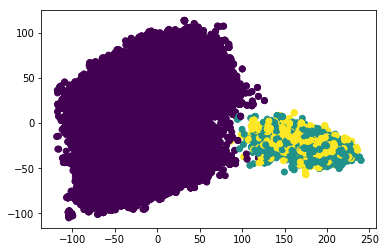

In [42]:
plot_clusters(clusters, vectorized_players)

# KMeans++

In [30]:
def dist(a,b):
    return np.linalg.norm(a-b)

def KPP(data, c1, k=3):
    n = len(data)
    
    assignments = dict([(_, 0) for _ in range(n)])
    clusters = np.empty([k,len(c1)])
    clusters[0, :] = c1
    
    for i in range(1,k):
        weights = np.array([dist(d, clusters[assignments[idx], :])**2 for idx,d in enumerate(data)])
        weights = weights/sum(weights)
        centerIdx = np.random.choice(list(range(n)), p=weights)
        clusters[i,:] = data[centerIdx,:]
        for j in range(n):
            if dist(data[j,:], clusters[assignments[j], :]) > dist(data[j,:], clusters[i,:]):
                assignments[j] = i
    arr = [dist(d, clusters[assignments[idx],:]) for idx,d in enumerate(data)]
    max3cenCost = max(arr)
    mean3Cost = sqrt(sum([x**2 for x in arr])/len(arr))
   
    data = np.append(data, np.array([[i] for i in list(assignments.values())]), axis=1)
    return data, max3cenCost, mean3Cost, clusters

In [31]:
kmpp_clusters, kmpp_three_cen_cost, kmpp_three_mean_cost, kmm_centers = KPP(temp, temp[0,:], k=3)

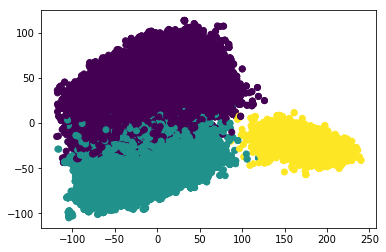

In [44]:
plot_clusters(kmpp_clusters, vectorized_players)

# Lloyds

In [33]:
def Lloyds(data, init_centers, k=3, r=10):
    n = len(data)
    centers = np.copy(init_centers)
    assignments = defaultdict(list)
    for _ in range(r):
        old = np.copy(centers)
        clusterIdx = defaultdict(list)
        for i in range(n):
            d = data[i,:]
            minDist = np.argmin(np.apply_along_axis(dist, 1, centers, d))
            clusterIdx[minDist].append(i)
            assignments[i] = minDist
        for i in range(k):
            idxs = clusterIdx[i]
            subset = data[idxs, :]
            centers[i,:] = np.average(subset, axis=0)
        if np.allclose(old, centers):
            break
            
    arr = [dist(d, centers[assignments[idx],:]) for idx,d in enumerate(data)]
    max3cenCost = max(arr)
    mean3Cost = sqrt(sum([x**2 for x in arr])/len(data))
    data = np.append(data, np.array([[i] for i in list(assignments.values())]), axis=1)
   
    return data, max3cenCost, mean3Cost, centers

## Lloyds with KMeans++ centers

In [34]:
ll_clusters, ll_max3cenCost, ll_mean3Cost, ll_centers = Lloyds(temp, kmm_centers, k=3)

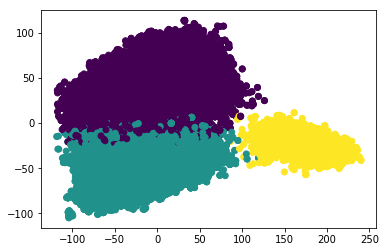

In [46]:
plot_clusters(ll_clusters, vectorized_players)

## Lloyds with Gonzales centers

In [ ]:
ll_g_clusters, ll_g_max3cenCost, ll_g_mean3Cost, ll_g_centers = Lloyds(temp,  centers, k=3)

In [ ]:
plot_clusters(ll_g_clusters)


Labels [2 2 2 ... 0 0 0]

Centers [[60.903139   65.94594595 58.04513213 66.29708829 62.768448   70.36117461
  62.8053636  57.45338524 57.19202383 70.84887594 74.04023356 73.71229083
  72.95162828 67.15134613 69.38739174 69.60799707 65.16551931 67.15998067
  63.54012253 64.07451047 54.94735673 40.01665513 67.39000431 64.59557431
  63.69739919 30.67950309 34.98069311 32.06916777  9.8448134  11.58144031
  16.241114   11.45103392 11.43396079]
 [18.750393   18.1662224  19.17797827 28.04791197 17.3258834  18.87423963
  17.66967398 18.43852095 33.44433053 24.1682045  45.73111886 46.08673365
  48.31870686 62.79666462 47.6223088  28.70829062 64.9807942  41.41863167
  63.75326362 18.44658602 36.2410635  26.57446518 20.74786412 31.24919691
  29.26006425 18.46121249 18.9618618  18.05467842 69.72223361 66.23894471
  64.09309001 67.03930012 71.31747659]
 [56.16729842 41.45700348 62.84148256 64.86622182 43.36568353 56.36770214
  50.38187731 47.55167657 60.87122351 63.55114949 65.88054278 66.89703936

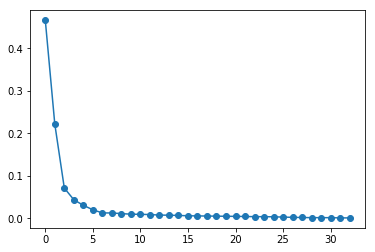

In [36]:
kmeans = KMeans(n_clusters=3).fit(vectorized_players)

pca = PCA()

pca_dataset = pca.fit_transform(vectorized_players)

cdict = mpl.colors.ListedColormap(['red', 'green', 'blue', 'gray'])


print()
print("Labels", kmeans.labels_)
print()
print("Centers", kmeans.cluster_centers_)
print()
print(pca.explained_variance_ratio_)
plt.plot(range(len(vectorized_players[0])), pca.explained_variance_ratio_, '-o')
plt.show()

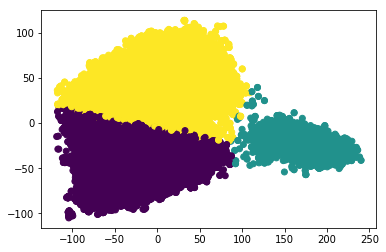

In [41]:
# db = DBSCAN(eps=50, min_samples=2).fit_predict(vectorized_players)

# print(max(db))
# print(min(db))
# print(len(set(db)))

plt.scatter(pca_dataset[:,0], pca_dataset[:,1], c=kmeans.labels_)
plt.show()